In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from fastai.vision.all import * 
path=untar_data(URLs.PETS) # defined in fastai, Oxford-IIIT Pet Dataset download URL

In [2]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [3]:
(path/"images").ls()[0]

Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg')

## Presizing
#### 핵심: 1) 크게 만들고 → 2) 랜덤하게 자른다
#### Step 1: CPU에서 큰 사이즈로 Resize 
        - 왜 크게? → 나중에 crop해도 빈 공간 안 생김 
#### Step 2: GPU에서 Random Crop + Augmentation
        - 모든 augmentation 한방에 → interpolation 1번만
        - 매번 다른 부분 crop → 다양성 확보
        - min_scale은 random crop의 최소 크기 지정 (이미지의 최소 75%는 포함)

In [5]:
pets = DataBlock(
    # 입력은 이미지, 출력은 카테고리
    blocks = (ImageBlock, CategoryBlock),
    
    # 이미지 파일들 찾기
    get_items = get_image_files,
    
    # 80/20으로 train/valid 나누기
    splitter = RandomSplitter(seed=42),
    
    # 라벨 추출: 'beagle_123.jpg' → 'beagle'
    get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),

    # Presizing
    # 개별 이미지 변환: 460x460으로 Resize --> CPU: 한 번만 실행 
    item_tfms = Resize(460),
    
    # 배치 단위 증강: 224x224로 랜덤 크롭 + 각종 증강 --> GPU: 매번 다르게 
    batch_tfms = aug_transforms(size=224, min_scale=0.75)
)
dls = pets.dataloaders(path/"images")

Step-by-Step Explanation:

- DataBlock: Defines only how to process data (blueprint)
- dataloaders(): Creates DataLoaders with actual data from the path
- path/"images": The actual folder path where images are located

Analogy:

- DataBlock = Recipe
- dataloaders() = Actually cooking according to the recipe
- path/"images" = Where the ingredients are

The reason for this separation: You can process different datasets with the same recipe

## Checking & Debugging a DataBlock

### Why Debugging Matters
#### When building a DataBlock, mistakes won't show up until you try to create a batch. This can waste valuable time if you only discover errors during training. That's why debugging your DataBlock early is crucial.

### The Power of summary()
##### pythonpets1.summary(path/"images")
#### The summary() method is your best friend for debugging. It shows:
    - Data collection process: How files are found and loaded
    - Transform pipeline: Each transformation step applied
    - Exact error location: Pinpoints where things go wrong
    - Sample data flow: Shows actual data at each step
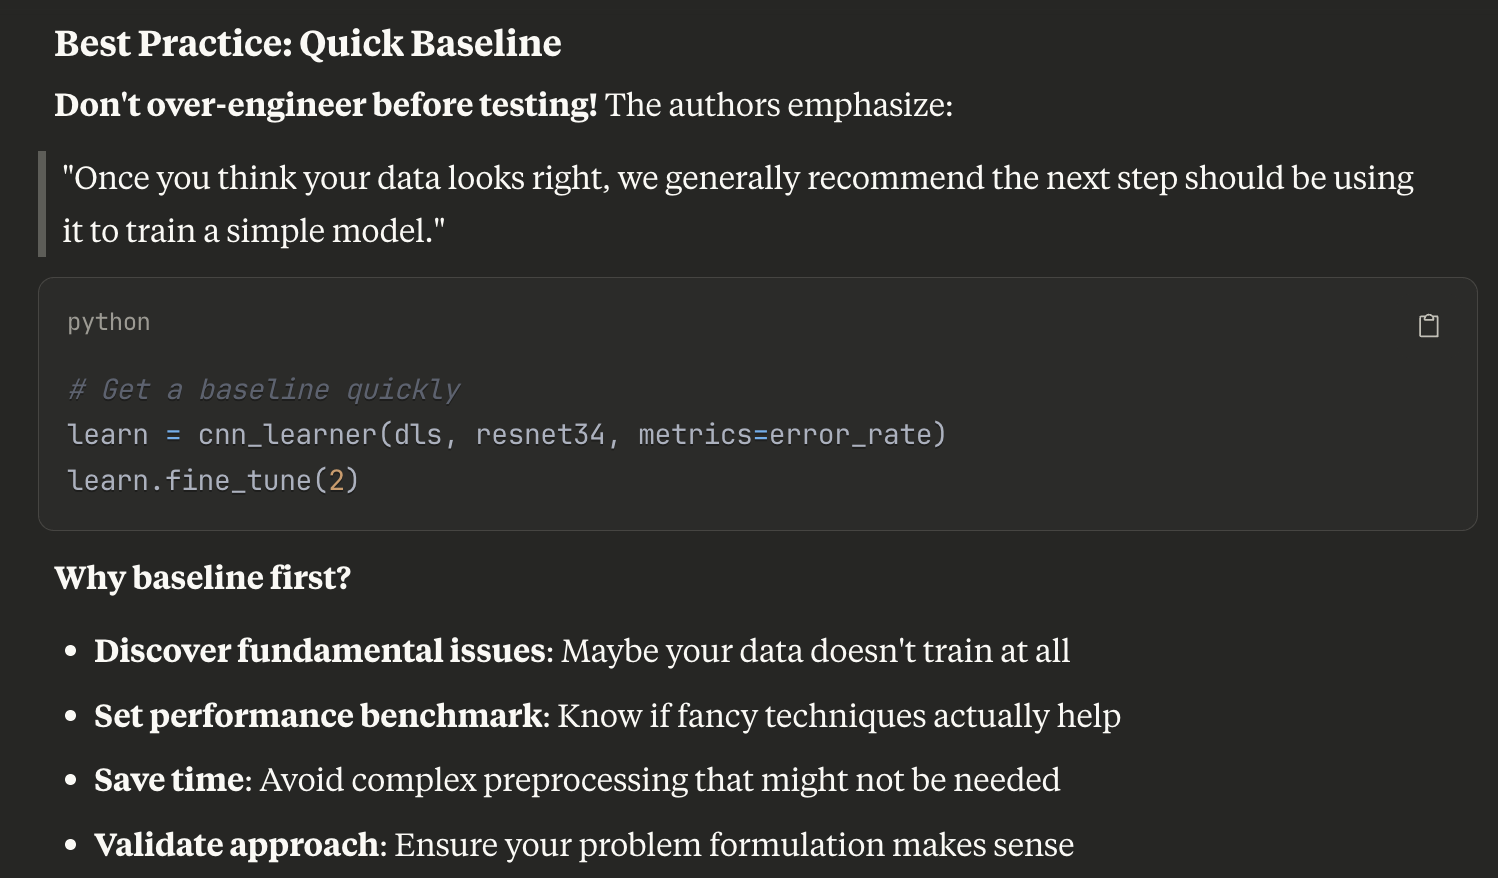

### Key Takeaways

    - Always use summary() before training to catch errors early
    - Remember Resize - forgetting it is the #1 mistake
    - Start simple - get a baseline before complex preprocessing
    - Debug systematically - follow the data flow through each transform
    - Don't delay training - test with a simple model ASAP

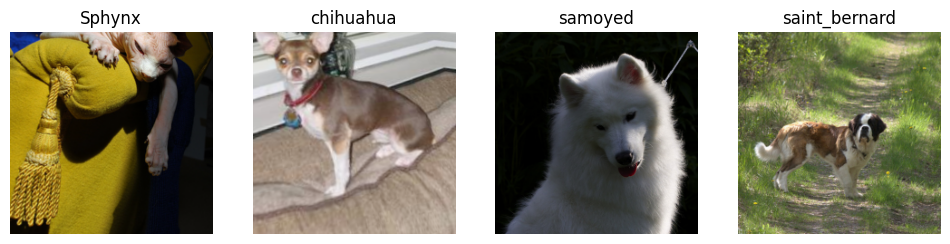

In [6]:
# Before training a model, we should always check our data
dls.show_batch(nrows=1, ncols=4) # by show_batch method, we can check that each pic seems to have the correct label for that breed of pet.

In [7]:
# summary method
# e.g. pets1 --> one common mistake; forgetting to use a Resize transform
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"), "name"))
pets1.summary(path/"images") # Shows exactly at which point the error happens

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/basset_hound_43.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=333x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/basset_hound_43.jpg
    applying partial gives
      basset_hound
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(14)

Final sample: (PILImage mode=RGB size=333x500, TensorCategory(14))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up afte

RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 500, 333])
	Item at index 1 has shape: torch.Size([3, 375, 500])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size

## Why Run a Quick Baseline First?

1. **Inspect → Train Immediately**  
   - After verifying your data visually (e.g., `dls.show_batch()`), train a **small, simple model** right away to see if the task is *at least* learnable.

2. **Avoid Over-Engineering Early On**  
   - Spending days on elaborate preprocessing or custom architectures can waste time if you don’t even know the baseline.  
   - If a plain network with default hyper-parameters gets you close to target performance, that’s a valuable signal.  
   - If the model barely learns (loss stays high or error ≥ 90 %), suspect issues with labels, splits, or data quality first.


## 1. Terminology 
| Term        | Plain Meaning | Why It Matters |
|-------------|---------------|----------------|
| **Backbone**| Pre-trained CNN body (e.g., `ResNet-34`) that already “knows” generic visual patterns from ImageNet. | Re-using it speeds up convergence and cuts data/compute cost. |
| **Head**    | New classifier layers added on top of the backbone. | Adapts the generic features to **your** labels. |
| **Freeze / Unfreeze** | Toggle whether backbone weights get updated. | Two-phase training: **freeze** for stability ➜ **unfreeze** for fine-tuning. |
| **Baseline**| First, simplest model+hyperparams you test. | Establishes a numeric yardstick before fancy tweaks. |

---

## 2. `cnn_learner` in One Sentence
> **`cnn_learner(dls, arch, metrics=…, …)` builds a Learner with a pretrained backbone + new head, auto-picks loss-fn/optimizer, and readies it for GPU—all in one line.**

---

## 3. Minimal Workflow
```python
from fastai.vision.all import *

# ① data
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=Resize(224))

# ② learner (baseline)
learn = cnn_learner(dls, resnet34, metrics=error_rate)

# ③ train: 1 epoch frozen + 2 epochs unfrozen  (=3 total)
learn.fine_tune(2)
```
What Happens Internally?
	1.	Freeze phase (1 epoch) → only the head learns.
	2.	Unfreeze phase (2 epochs) → entire network fine-tunes.

In [8]:
# Create baseline CNN model using pre-trained ResNet34 (transfer learning)
# dls: DataLoaders object with our prepared train/validation datasets
# metrics=error_rate: track error rate during training
# Loss function: fastai auto-selects cross-entropy for image classification
learn = cnn_learner(dls, resnet34, metrics=error_rate)

# Fine-tune the model (3 epochs total):
# - 1 epoch with frozen pre-trained layers (only train classifier head)
# - 2 epochs with unfrozen layers (train entire model)
# Each epoch = one complete pass through all training images
# Output columns: train_loss | valid_loss | error_rate
learn.fine_tune(2)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 186MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.493450,0.343739,0.110961,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.524822,0.388220,0.112991,00:30
1,0.319287,0.254636,0.080514,00:30


## Reading `train_loss` vs `valid_loss`

- **Both ↓** Healthy learning, no overfitting yet.  
- **`train_loss` ↓ but `valid_loss` flat/↑** Overfitting—model memorizes the training set.  
- **Both high, barely moving** Model cannot learn → check labels, splits, or architecture.

---

## Quick Debug Checklist

| Symptom | Likely Cause | Fast Fix |
|---------|--------------|----------|
| Loss not changing | Label mismatch, corrupt data | Re-inspect `dls.show_batch()`, label pipeline |
| `train_loss` ↓, `valid_loss` ↑ | Overfitting | Add augmentation, weight-decay, dropout, early-stop |
| Error rate ≈ random (e.g., 0.5 for binary) | Shuffled labels, bad splitter | Verify folder/CSV labels, random seed |
| Epoch time unusually long | GPU off or I/O bottleneck | Ensure `device='cuda'`, increase `num_workers` |

---

## Bottom Line

> **Baseline first, polish later.**  
> A quick, frozen-then-unfrozen ResNet-34 run tells you in minutes whether the task is learnable, your data pipeline is sane, and where to focus next.

### Cross-Entropy Loss

Why use it? 
Measures distance between true vs predicted probability distributions


In [9]:
x,y = dls.one_batch() #this returns the dependent and independent variables
# x: input images, y: true labels

In [10]:
y # in our dependent varible, there are:

TensorCategory([ 3, 16, 32, 15, 32,  0, 27, 28, 31, 27, 31, 36, 28, 13, 36,  4,
                 8, 25,  6, 13, 30,  1,  9, 25, 20, 15, 32, 29, 17, 27, 15, 21,
                24, 33, 25,  5, 35,  7, 23, 12,  2,  6, 11, 19, 28,  6,  6,  5,
                30, 13, 34, 28,  9, 17, 36, 19, 24,  6, 24, 13, 17, 28, 28, 32],
               device='cuda:0')

In [11]:
preds,_=learn.get_preds(dl=[(x,y)])

# get_preds() internally:
# logits = model(x)  # [-2.1, 0.8, 3.2, ...]
# preds = softmax(logits)  # [0.01, 0.15, 0.84, ...] (sum to 1)

preds[0] # prob of each of 37 breeds, which add up to 1 in total

tensor([1.0028e-04, 5.7879e-06, 1.5928e-04, 9.9620e-01, 1.6709e-04, 1.9575e-05,
        7.6129e-04, 1.4555e-04, 2.8089e-04, 1.7916e-03, 3.9525e-05, 3.4044e-06,
        1.3116e-06, 8.2488e-07, 4.1618e-06, 1.3227e-05, 9.0357e-06, 8.8056e-06,
        7.0203e-05, 2.7802e-06, 4.1433e-06, 1.1183e-06, 2.6007e-05, 9.8248e-06,
        1.6153e-06, 1.4268e-06, 6.6769e-06, 2.1686e-05, 8.2178e-06, 2.8330e-05,
        1.8158e-06, 4.7284e-06, 6.6499e-06, 1.1077e-05, 1.4205e-05, 5.4552e-07,
        6.3120e-05])

### From Input to Probability: Logit → Softmax Process
#### What is Logit?
#### Logit = Raw output scores from neural network's final layer (before activation)
    - Can be any real numbers (positive, negative, or zero)
    - No constraints on range or sum

### The Complete Process
    - Step 1: Input to Logits
    x (input) → Neural Network → logits
    Example:

    Input: dog image
    Logits: [-2.1, 0.8, 3.2, -1.5, 0.3] (raw scores for 5 classes)

    - Step 2: Logits to Probabilities (Softmax)
    Softmax Formula:
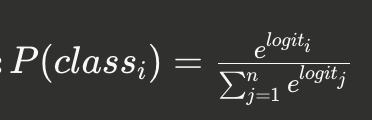
    
    
Step-by-step calculation:

#### Exponentiate: $e^{logit_i}$ for each logit
#### Sum all: $\sum e^{logit_j}$
    Normalize: Divide each by the sum

    - Example Calculation
    Given logits: [-2.1, 0.8, 3.2, -1.5, 0.3]

    Exponentiate:

#### $e^{-2.1} = 0.122$
#### $e^{0.8} = 2.226$
#### $e^{3.2} = 24.533$
#### $e^{-1.5} = 0.223$
#### $e^{0.3} = 1.350$
    
    
#### Sum: $0.122 + 2.226 + 24.533 + 0.223 + 1.350 = 28.454$
    Probabilities:
    
#### $P_1 = 0.122/28.454 = 0.004$
#### $P_2 = 2.226/28.454 = 0.078$
#### $P_3 = 24.533/28.454 = 0.862$
#### $P_4 = 0.223/28.454 = 0.008$
#### $P_5 = 1.350/28.454 = 0.047$


    
    Result: [0.004, 0.078, 0.862, 0.008, 0.047] ✓ Sum = 1.0
    - Key Properties

    Logits: Unbounded real numbers
    Softmax output: Valid probability distribution (0 ≤ p ≤ 1, Σp = 1)
    Highest logit → Highest probability

In [ ]:
len(preds[0]),preds[0].sum() # 37 probabilities between 0 and 1, which add up to 1 i

## Softmax → Cross-Entropy in a Nutshell

### Softmax (multi-class activation)
For logits $\mathbf{x} = [x_1, \dots, x_K]$  
$ \[
\text{softmax}(x_i) \;=\; \frac{e^{x_i}}{\sum_{j=1}^{K} e^{x_j}}
\]$

* Maps each logit to $(0,1)$  
* Ensures $\sum_{i=1}^{K} p_i = 1$ (valid probability vector)  
* Exponential term amplifies small logit differences → the largest logit dominates

---

### Why not just sigmoids?
* Independent sigmoids give $K$ **unrelated** probabilities; rows don’t sum to $1$
* Softmax enforces **mutual exclusivity** (“exactly one class is correct”)

---

### Cross-Entropy Loss (CE)
Given one-hot target $\mathbf{y}$ and predicted probs $\mathbf{p}$ from softmax,
$ \[
\mathcal{L}_{\text{CE}}(\mathbf{y},\mathbf{p})
\;=\;
-\sum_{i=1}^{K} y_i \,\log p_i
\] $

* Penalizes low probability on the true class (high $-\log p_{\text{true}}$)  
* PyTorch’s `nn.CrossEntropyLoss` **expects raw logits**; it internally applies softmax + log

---

### Workflow Summary
1. **Model outputs logits** $\mathbf{x}$
2. **`CrossEntropyLoss`** → softmax$(\mathbf{x})$ → probabilities $\mathbf{p}$ → compute CE
3. Back-propagate CE to update the logits and the model weights

> **Rule of thumb**  
> *Single correct label* → **softmax + cross-entropy**  
> *Multiple labels possible* → **sigmoid (per class) + binary CE**

In [12]:
# example> a NN that predicts 3s and 7s that returns two activations, one for each class
# (1) Generate synthetic logits: 6 samples × 2 classes
#     std=2 widens the range so we see both positive and negative values.
acts = torch.randn((6,2))*2 # multiplied randon by 2 for std 2
acts

tensor([[-2.7469,  1.2929],
        [-3.3264, -0.6674],
        [-1.2777,  1.2582],
        [ 1.1777,  2.5570],
        [-1.6045, -3.3076],
        [ 2.2148, -2.0914]])

In [13]:
# (2) Apply an element-wise sigmoid *independently* to every logit.
#     Rows no longer sum to 1; each column is treated as its own binary task.
acts.sigmoid()

tensor([[0.0603, 0.7846],
        [0.0347, 0.3391],
        [0.2179, 0.7787],
        [0.7645, 0.9280],
        [0.1674, 0.0353],
        [0.9016, 0.1099]])

In [14]:
# (3) Binary-class trick:  P(class-0) = σ(logit₀ − logit₁)
#     Works because only the *difference* matters when there are exactly two classes.
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.0173, 0.0654, 0.0734, 0.2011, 0.8459, 0.9867])

In [15]:
# (4) Softmax — generalizes sigmoid to “K classes, exactly one true”.
def softmax(x): 
    exp_x= exp(x) 
    return exp_x / exp_x.sum(dim=1, keepdim=True)

sm_acts=torch.softmax(acts, dim=1) 
sm_acts # same as the above (sigmoid = softmax when there are two classes)

tensor([[0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133]])

| Scenario | Recommended Output & Activation | Loss Function |
|----------|---------------------------------|---------------|
| **Binary only**<br>(heavily imbalanced, AUC/PR focus) | 1 logit(score) + **sigmoid** | `BCEWithLogitsLoss` |
| **Binary but may expand to multi-class** | 2 logits(scores) + **softmax** | `CrossEntropyLoss` |
| **3 or more classes** | K logits + **softmax** | `CrossEntropyLoss` |

### Log Likelihood

In [16]:
# ➊ lables : 6 samples, 0 or 1
targ = tensor([0, 1, 0, 1, 1, 0])

# ➋ softmax activations (6×2 tensor)
sm_acts


tensor([[0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133]])

In [17]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.0173, 0.9346, 0.0734, 0.7989, 0.1541, 0.9867])

In [18]:
print(-sm_acts[idx,targ]) # takes the negative bcz we'll have negative numbers after applyung the log afterward
print(F.nll_loss(sm_acts, targ, reduction="none"))
# loss = F.nll_loss(logp, targets) 
# but we did not thae the log here --> gives the same result as -sm_acts[,]


tensor([-0.0173, -0.9346, -0.0734, -0.7989, -0.1541, -0.9867])
tensor([-0.0173, -0.9346, -0.0734, -0.7989, -0.1541, -0.9867])


## Why Take the Log in Loss Functions?

### 1. Gradient Resolution  
Small probability tweaks can hide inside the 0‒1 range.  
Example (natural log):

| $p$     | $-\log p$ | Penalty size |
|---------|-----------|--------------|
| 0.90    | 0.105     | mild         |
| 0.99    | 0.010     | **10× smaller** |
| 0.999   | 0.001     | **another 10×** smaller |

$\rightarrow$ Using $-\log p$ stretches tiny gaps (0.99 → 0.999) into clearly different penalties.

### 2. Numerical Stability  
Multiplying many small probs drives values toward **underflow**:  
$\displaystyle p_1p_2\ldots p_n \to 0$.  
Log turns products into sums:  
$\displaystyle \log(ab)=\log a+\log b$  →  safer to accumulate, no vanishing to zero.

### 3. Information Theory  
$-\log p$ measures “surprise” in **bits**.  
Cross-Entropy sums these surprises to quantify how far the predicted distribution is from the truth.

> **In short:** logs 1) sharpen gradients, 2) prevent numerical collapse, and 3) give an information-theoretic meaning to the loss.


In [19]:
loss_func = nn.CrossEntropyLoss() # which performs log_softmax --> nll_loss

In [20]:
loss_func(acts, targ) # acts: score rangning from -2 to +2 
# loss_func: acts --> log(softmax(acts)) --> NLL

tensor(1.4743)

In [21]:
F.cross_entropy(acts, targ) # a plain functional form is available in the F namesapace

tensor(1.4743)

### Model Interpretation

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('american_pit_bull_terrier', 'american_bulldog', 7),
 ('Bengal', 'Egyptian_Mau', 6),
 ('Egyptian_Mau', 'Bengal', 5)]

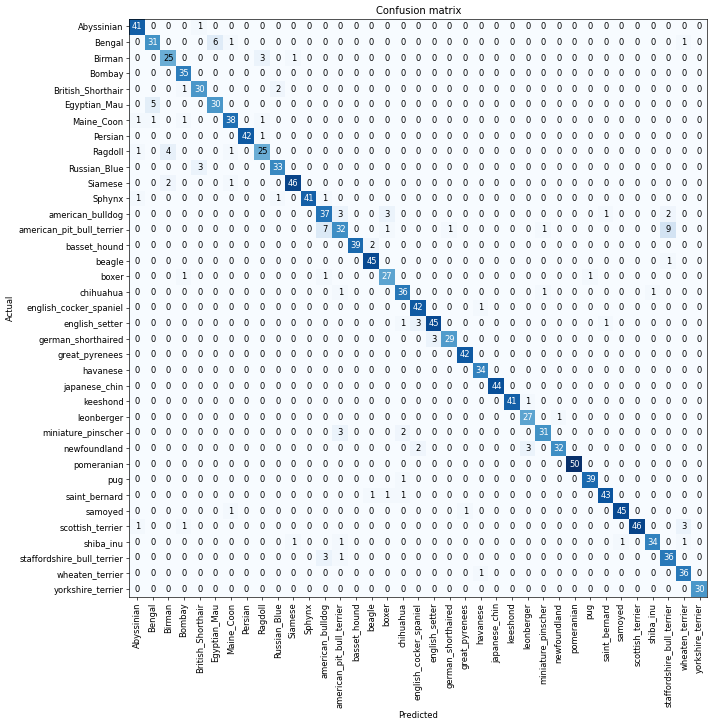

In [22]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)

# Confusion matrix (37*37)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# The most incorrect predictions (at least 5 incorrect preds)
interp.most_confused(min_val=5)

The Learning Rate Finder

In [23]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1) # head only - 1 epoch, total network - 1 epoch
# 0.1 learning rate --> too high: overshooting, error rate increased

epoch,train_loss,valid_loss,error_rate,time
0,2.773521,4.363466,0.478349,00:28


epoch,train_loss,valid_loss,error_rate,time
0,4.383031,3.504344,0.917456,00:30


minimum/10 → 1.20e-02,  steepest → 2.51e-03


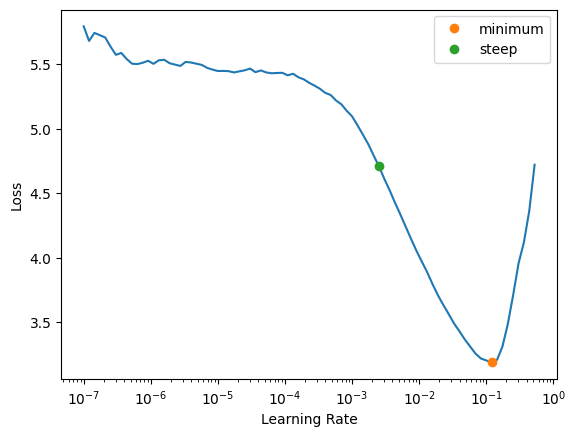

In [25]:
# To find a optimal lr
from fastai.callback.schedule import steep, minimum
learn = cnn_learner(dls, resnet34, error_rate)
# tell lr_find to return (minimum, steep) instead of just one of them
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

print(f"minimum/10 → {lr_min:.2e},  steepest → {lr_steep:.2e}")


## Choosing an Appropriate Learning Rate (≈3e-3)

- **Steepest Descent Region**  
  - Around **10⁻³**, the loss curve begins to drop most sharply.  
  - Selecting a learning rate here ensures we move quickly down the loss surface without wasted small steps.

- **Avoiding Overshoot**  
  - Going much higher (≳10⁻¹) causes the optimizer to jump past the minimum and the loss to rise.  
  - Staying below the “minimum/10” point (≈8×10⁻³) keeps training stable.

- **Balancing Speed and Stability**  
  - **3e-3** (i.e. 3×10⁻³ = 0.003) sits between the “steepest” point (~6×10⁻³) and the “minimum/10” point (~8×10⁻³).  
  - This conservative midpoint maximizes convergence speed while minimizing the risk of divergence.

> **Note:**  
> “3e-3” means **3 × 10⁻³**, or **0.003**.

### Unfreezing and Transfer Learning

### 1. Transfer Learning의 의미

#### 1.1 백본(Backbone)의 역할
- ImageNet 등 큰 데이터셋으로 사전학습된 CNN(예: ResNet)은  
  - **초반 레이어**: 엣지·모서리 같은 일반적인 특징  
  - **중간 레이어**: 형태·질감  
  - **후반 레이어**: 물체나 패턴의 고수준 표현  
- 이 “일반적인 시각 특징”을 **재사용**하려는 것이 **transfer learning**

#### 1.2 마지막 분류층(Head) 교체
- 원래 사전학습된 모델의 **마지막 FC 레이어**는 ImageNet의 1,000개 클래스를 분류하도록 설계됨  
- 우리 과제(예: 애완동물 품종 37개)에 맞추려면  
  1. 해당 레이어를 **버리고**  
  2. 원하는 클래스 수(37)만큼 출력 뉴런을 가지는 **새로운 FC 레이어**를 붙여야 함  
  3. 이 새 레이어는 **랜덤 가중치**로 초기화  

---

### 2. “Freeze” 단계

- **동기**  
  - 사전학습된 백본 가중치는 이미 일반적인 특징을 잘 잡아내도록 학습돼 있으므로,  
  - **처음부터 헤드만 학습**시켜 “내 태스크”에 빠르게 적응시키자

- **동작**  
  1. Optimizer에 **백본 파라미터**는 `requires_grad=False`로 설정  
  2. 오직 **추가한 FC 레이어(헤드)**만 `requires_grad=True`  
  3. `learn.fine_tune(...)` 호출 시 **첫 에폭(기본 1번)** 은 이 상태로 학습  

---

### 3. “Unfreeze” 단계

- **동기**  
  - 헤드가 내 데이터에 맞춰 어느 정도 잡히면,  
  - 백본도 **미세 조정**(fine-tune)하여 도메인에 더 특화된 표현을 학습하도록 하자

- **동작**  
  1. `learn.fine_tune` 내부에서 **첫 에폭 후**  
  2. **모든 레이어**(`requires_grad=True`)를 **언프리즈**(unfreeze)  
  3. **나머지 에폭 동안**(예: 추가 2번) **백본+헤드 전부** 학습  

In [28]:
learn=cnn_learner(dls, resnet34)
learn.freeze??

Signature: learn.freeze()
Docstring: Freeze up to last parameter group
Source:   
@patch
def freeze(self:Learner): self.freeze_to(-1)
File:      /usr/local/lib/python3.11/dist-packages/fastai/learner.py
Type:      method


In [32]:
learn = cnn_learner(dls, resnet34, error_rate) 
# requires_grad=False for the body, requires_grad=True for the head 
# FastAI automatically calls learn.freeze() to do this
learn.fit_one_cycle(3, 3e-3) # 3 epoch동안, head(새로 추가한 FC layer만) 학습
# lr = 0.003을 최대값으로 잡아 1cycle 적용 


epoch,train_loss,valid_loss,time
0,1.124454,0.298573,00:35
1,0.517858,0.244871,00:34
2,0.322853,0.219758,00:34


In [33]:
# unfreeze --> lr_find 
# 왜 다시 하나? --> 이제 backbone까지 학습대상, 랜덤으로 초기화된 head만 학습시 찾은 lr(3e-3)은 더이상 최적이 아님
learn.unfreeze()


SuggestedLRs(valley=7.585775892948732e-05)

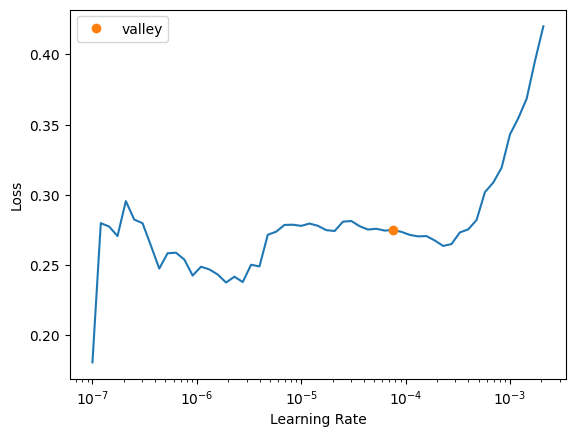

In [34]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(6, lr_max=1e-5) # 6 epoch, 모든 레이어(unfreeze)를 학습 대상으로, 최대 lr=1e-5

epoch,train_loss,valid_loss,time
0,0.267145,0.212836,00:35
1,0.253683,0.209227,00:36
2,0.230484,0.202976,00:36
3,0.198976,0.195541,00:36
4,0.182334,0.196503,00:37
5,0.174632,0.194832,00:37


## `learn.freeze()` vs `learn.unfreeze()`

- **`learn.freeze()`**  
  - **백본(body)**: `requires_grad=False` → **동결(frozen)**  
  - **헤드(head)**: `requires_grad=True` → **학습 대상**

- **`learn.unfreeze()`**  
  - **모든 레이어**(`body` + `head`): `requires_grad=True` → **전체 네트워크 학습 대상**

### 사용 예시

```python
from fastai.vision.all import *

# 1) Learner 생성 (백본 자동 동결)
learn = cnn_learner(dls, resnet34, metrics=error_rate)

# 2) freeze 단계: 헤드만 학습
learn.freeze()
learn.fit_one_cycle(3, 3e-3)

# 3) unfreeze 단계: 전체 네트워크 학습
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=1e-5)
```
- **`learn.fine_tune(epochs, base_lr)`**  
  빠르고 간단하게 **freeze → fit → unfreeze → fit**을 한 번에 실행해 주는 메서드
  ```python
  # 내부적으로 다음 두 단계를 한 줄로 처리
  learn.fine_tune(3, base_lr=3e-3)
  # 1) 헤드만 1 epoch 학습 (freeze + fit_one_cycle)
  # 2) 전체 네트워크 2 epoch 학습 (unfreeze + fit_one_cycle)

### Discriminative Learning Rates
- **문제의식**  
  - 사전학습된 백본은 **수백 에폭, 수백만 이미지**로 이미 학습된 가중치  
  - **가장 낮은 레이어**(엣지·모서리)   → 거의 모든 시각 태스크에 유용  
  - **가장 높은 레이어**(“눈”, “일몰” 등) → 도메인마다 유용도가 다름  
  - 따라서 **모든 레이어에 같은 학습률**을 쓰면 초반 레이어는 과도하게 바뀌고 최종 레이어는 학습이 느려질 수 있음

- **Core Idea** : **different layers of a neural network should train at different speeds!**
  1. **초반 레이어**에는 **낮은 학습률**  
  2. **후반 레이어**(특히 새로 추가한 헤드)에는 **높은 학습률**  
  3. 이렇게 하면 “일반적인 특징”은 천천히 보존하면서 “도메인 특화 표현”은 빠르게 학습 가능

- **FastAI 사용법**  
  ```python
  # Learner 생성 (기본적으로 freeze 상태)
  learn = cnn_learner(dls, resnet34, metrics=error_rate)
  learn.freeze()

  # discriminative LR: slice(초반_lr, 후반_lr)
  # 예: 1e-6 → 1e-4 구간에 걸쳐 학습률 차등 적용
  learn.fit_one_cycle(
      5,
      lr_max = slice(1e-6, 1e-4)
  )

In [39]:
# fastAI로 레이어별 lr 적용
# 1) Head 먼저 3 epoch 학습
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3) # 기본적으로 loss 줄어듦 

epoch,train_loss,valid_loss,error_rate,time
0,1.157085,0.326764,0.097429,00:37
1,0.547016,0.267996,0.085927,00:37
2,0.339741,0.238682,0.068336,00:37


In [40]:
# 2) 전체 네트워크 unfreeze + discriminative LR
learn.unfreeze()
learn.fit_one_cycle(12, lr_max = slice(1e-6, 1e-4)) 
# slice--> 초반 레이어 그룹 lr≈1×10⁻⁶ --> 후반 레이어그룹 (head) lr≈1×10⁻⁴
# 중간 layers -- 초반과 후반 레이어 사이를 interpolation 

epoch,train_loss,valid_loss,error_rate,time
0,0.273488,0.234094,0.071719,00:38
1,0.255742,0.217590,0.072395,00:38
2,0.242505,0.211491,0.071042,00:37
3,0.210038,0.206192,0.066982,00:37
4,0.187592,0.205400,0.071042,00:37
5,0.176389,0.202476,0.067659,00:36
6,0.155280,0.200416,0.068336,00:37
7,0.154584,0.207132,0.067659,00:37
8,0.133394,0.202485,0.066306,00:36
9,0.130107,0.199444,0.063599,00:36


Train loss keep decreases, but error rate increases past epoch=6, which demonstrates overfitting

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

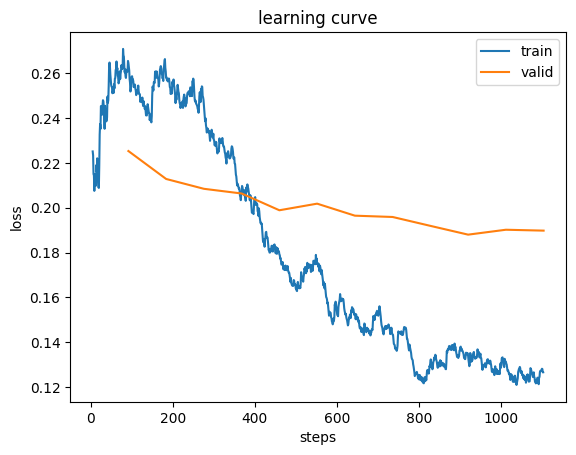

In [38]:
learn.recorder.plot_loss()

## 표와 그래프 요약

- **train_loss ↓, valid_loss plateau/↑** --> overfitting

- **error_rate**(또는 **accuracy**)만 보고 **학습 중단 시점** 판단  
  손실(loss) 대신 우리가 실제로 중요하게 생각하는 **정확도** 기준으로 멈추기

> **핵심**  
> 1. 학습 결과를 보면, **validation loss**가 올라가더라도 accuracy(또는 사용자가 정의한 메트릭)가 계속 개선될 수 있음  
> 2. 최종 평가는 **loss**가 아니라 **accuracy** 등 메트릭으로 해야 함.  
> 3. loss는 **단지 컴퓨터가 최적화할 수 있도록 제공한 도구**일 뿐임.

## Selecting the Number of Epochs

1. **시간 제한 고려**  
   - 일반화 성능보다 **실제 사용 가능한 학습 시간**이 우선임 
   - **허용 가능한 대기 시간** 안에 끝낼 수 있는 에폭 수를 먼저 정해야 함

2. **메트릭(정확도 등) 모니터링**  
   - 학습 후 **train/valid 손실 곡선**과 **선택한 메트릭**을 확인 
   - 마지막 epoch에서도 metric이 계속 개선된다면 **더 학습해야 했다**는 신호

3. **validation loss vs. overfitting 주의**  
   - validation loss --> over-confidence 단계에서 먼저 올라가고, 그 다음 “데이터 암기” 단계에서 추가로 악화 

4. **과거의 방식: Early Stopping**  
   - 각 에폭마다 모델을 저장한 뒤 **best metric**을 낸 체크포인트를 불러 사용  
   - 단점: 중간 에폭의 모델은 학습률 스케줄의 **최적 지점**을 놓칠 수 있음.

5. **권장 접근법**  
   - 과적합 징후가 보이면 **처음부터 재학습**하되,“최고 메트릭이 기록된 에폭 수”를 기준으로 **총 에폭 수**를 설정  
   - 시간 여유가 있다면 단순 에폭 증가보다 더 깊은 모델 아키텍처를 고려

> **요약**  
> 에폭 수는 “정해진 숫자”가 아니라,  
> 1) 시간 제약 → 2) 메트릭 추세 확인 → 3) 최적 지점 기반 재학습  
> 순으로 결정

## Deeper Architectures

- **Pros**  
  - 레이어와 파라미터가 많아질수록 데이터의 **복잡한 패턴**을 더 잘 모델링  
  - 더 낮은 **train_loss** 달성 가능

- **Cons**  
  1. **Overffiting 위험 증가**  
     - 표현력이 커질수록 학습 데이터 암기 가능성↑  
  2. **메모리 사용량↑ & 속도↓**  
     - 더 많은 GPU RAM 필요 → `out of memory` 오류  
     - 학습 속도도 느려짐

- **해결 방안**  
  1. **배치 크기 조절**  
     ```python
     # DataLoader에서
     dls = ImageDataLoaders.from_folder(path, bs=32)
     ```
  2. **Mixed-Precision Training (fp16)**  
     - half-precision(16-bit)으로 연산하여  
       - 연산 속도 2–3×↑, 메모리 사용량↓  
     - FastAI 적용:
     ```python
     from fastai.callback.fp16 import *
     learn = cnn_learner(dls, resnet50, metrics=accuracy).to_fp16()
     learn.fine_tune(6, freeze_epochs=3)
     ```

- **적용 예시**  
  ```python
  from fastai.callback.fp16 import *
  # ResNet-50 + fp16 + freeze 3 epochs
  learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
  learn.fine_tune(6, freeze_epochs=3)

## Conclusion


### 1. Practical Toolkit for Faster & More Accurate Image Models
- **Data Preparation**  
  - Resize & preprocess images  
  - Configure `DataBlock`/`DataLoader` (folder structure, labeling, split)

- **Learning Rate Finder**  
  - `learn.lr_find()` to identify the optimal learning rate

- **Freeze & Unfreeze**  
  - Freeze pretrained backbone → train head  
  - Unfreeze entire network → fine-tune all layers

- **Discriminative Learning Rates**  
  - Lower LR for early layers, higher LR for later layers  
  - `learn.fit_one_cycle(epochs, lr_max=slice(early_lr, late_lr))`

- **Epoch Selection**  
  - Balance wall-clock time vs. metric improvement  
  - Stop/retrain based on actual metrics (accuracy, error_rate), not just loss

- **Deeper Architectures**  
  - Scale up to ResNet-50/101 for more capacity  
  - Resolve OOM with smaller batch sizes & mixed-precision (`.to_fp16()`)

---

### 2. Deep Dive into Cross-Entropy Loss
- **Fundamental Loss for Classification**  
  - Understand `softmax → log → NLLLoss`  
  - Experiment with `nn.CrossEntropyLoss` vs. `BCEWithLogitsLoss`

- **Hands-On Practice**  
  - Manually implement each step on small tensors  
  - Visualize how changing loss functions (e.g. MSE, MAE) affects convergence

> **Note:**  
> The loss function is a tool for the optimizer.  
> **The true evaluation metrics** (accuracy, AUC, F1, etc.) are what matter in practice.